In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=  True)

Mounted at /content/gdrive/


In [2]:
%cd /content/gdrive/My Drive/optimum/20211106_TEXT/

/content/gdrive/My Drive/optimum/20211106_TEXT


In [3]:
import json
import pandas as pd
import numpy as np
import os
import re

In [4]:
nf = os.listdir(os.path.join('./', '노트북'))
wff = os.listdir(os.path.join('./', '여자 패션'))
mff = os.listdir(os.path.join('./', '남자 패션'))
of = os.listdir(os.path.join('./', 'OOTD'))
mbf = os.listdir(os.path.join('./', '모바일'))
itf = os.listdir(os.path.join('./', 'IT 제품'))

In [5]:
path_list = [nf, wff, mff, of, mbf, itf]

In [6]:
folder_names = ['노트북', '여자 패션', '남자 패션', 'OOTD', '모바일', 'IT 제품']

In [7]:
cn_list = []
sc_list = []
vc_list = []
cm_list = []
lc_list = []
c_list = []
f_list = []

In [8]:
for n in range(len(folder_names)) :
  file_folder = path_list[n]
  folder_name = folder_names[n]
  for f in file_folder :
    try : 
      data = open(os.path.join('./', f'{folder_name}/{f}'))
      data = json.loads(data.read())

      cn = data['channel_name']
      sc = data['subscribe_count']
      vc = data['view_count']
      cms = data['comment']
      lc = data['like_count']

      for cm in cms :
        f_list.append(f)
        c_list.append(folder_name)
        cn_list.append(cn)
        sc_list.append(sc)
        vc_list.append(vc)
        cm_list.append(cm)
        lc_list.append(lc)
    except :
      pass

In [9]:
df = pd.DataFrame({'카테고리' : c_list, '채널명' : cn_list, '파일명' : f_list, '구독자수' : sc_list, '조회수' : vc_list, '리뷰' : cm_list, '좋아요' : lc_list})

In [10]:
train = df[df.카테고리.isin(['여자 패션', '노트북'])]

In [11]:
test = df.query("index not in @train.index")

In [ ]:
train['target'] = train.리뷰.str[-1]

In [13]:
train = train[train.target.isin(['0', '1'])]

In [ ]:
train['target'] = train['target'].astype(int)

In [ ]:
train['리뷰'] = train['리뷰'].str[:-1]

In [ ]:
train['length'] = train.리뷰.apply(len)

In [17]:
train = train[train.length > 10]

In [ ]:
train.drop('length', axis = 1, inplace = True)

In [18]:
train.index = range(train.shape[0])

In [ ]:
train['리뷰'] = [re.sub(r'[^가-힣]+', ' ', s) for s in train['리뷰']]
test['리뷰'] = [re.sub(r'[^가-힣]+', ' ', s) for s in test['리뷰']]

In [ ]:
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy

In [ ]:
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
%%bash
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
pip3 install /tmp/mecab-python-0.996

In [ ]:
import konlpy
from konlpy.tag import Kkma, Komoran, Hannanum, Okt
from konlpy.utils import pprint
from konlpy.tag import Mecab
from tqdm import tqdm

In [ ]:
mecab = Mecab()

In [ ]:
tr_token = []

text = list(train['리뷰'])

for i in tqdm(range(len(text))):
  temp_X = []
  temp_X = mecab.pos(text[i]) # 토큰화
  tr_token.append(temp_X)

100%|██████████| 3169/3169 [00:00<00:00, 7311.10it/s]


In [ ]:
te_token = []

text = list(test['리뷰'])

for i in tqdm(range(len(text))):
  temp_X = []
  temp_X = mecab.pos(text[i]) # 토큰화
  te_token.append(temp_X)

100%|██████████| 13787/13787 [00:01<00:00, 10649.10it/s]


In [ ]:
tr_pos = []
for t in tr_token :
  token_list = []
  for c in np.arange(len(t)) :
    if t[c][1] in ['VV', 'VCP', 'VCN', 'VA', 'NP', 'NNP', 'NNG', 'MM', 'MAG', 'IC'] :
      token_list.append(t[c][0])
    else:
      pass
  tr_pos.append(token_list)

In [ ]:
te_pos = []
for t in te_token :
  token_list = []
  for c in np.arange(len(t)) :
    if t[c][1] in ['VV', 'VCP', 'VCN', 'VA', 'NP', 'NNP', 'NNG', 'MM', 'MAG', 'IC'] :
      token_list.append(t[c][0])
    else:
      pass
  te_pos.append(token_list)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,  ReduceLROnPlateau
from tensorflow.keras.regularizers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, RMSprop

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tr_pos)

In [ ]:
threshold = 5
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 4524
등장 빈도가 4번 이하인 희귀 단어의 수: 3416
단어 집합에서 희귀 단어의 비율: 75.50839964633069
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 16.334590373251775


In [ ]:
vocab_size = total_cnt - rare_cnt + 1 # 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거. 0번 패딩 토큰을 고려하여 +1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 1109


In [ ]:
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(tr_pos)
tr_tokenized = tokenizer.texts_to_sequences(tr_pos)
te_tokenized = tokenizer.texts_to_sequences(te_pos)

In [ ]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [ ]:
max_len = 62
below_threshold_len(max_len, tr_tokenized)

전체 샘플 중 길이가 62 이하인 샘플의 비율: 100.0


In [ ]:
tr_pt = pad_sequences(tr_tokenized, maxlen = max_len, padding = 'post')
te_pt = pad_sequences(te_tokenized, maxlen = max_len, padding = 'post')

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(tr_pt, train.target, test_size = 0.2, random_state = 42, stratify = train['target'])

In [ ]:
model1 = Sequential()
model1.add(Embedding(vocab_size, 64, input_length = max_len))
model1.add(Dropout(.25))
model1.add(Conv1D(64, 5, activation = 'relu', padding = 'same', kernel_regularizer = l2(0.01)))
model1.add(GlobalMaxPooling1D())
model1.add(Dense(1, activation = 'sigmoid'))
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 62, 64)            70976     
_________________________________________________________________
dropout_2 (Dropout)          (None, 62, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 62, 64)            20544     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 91,585
Trainable params: 91,585
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model1.compile(optimizer = RMSprop(learning_rate = .003), loss='binary_crossentropy', metrics=['accuracy'])
reLR = ReduceLROnPlateau(patience = 5, verbose = 1, factor = .95)
es = EarlyStopping(monitor = 'val_accuracy', mode = 'max', verbose = 1, patience = 10)
mc = ModelCheckpoint(filepath = 'optimum_cnn.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True, restore_best_weights = True)

In [ ]:
history1 = model1.fit(X_train, y_train, epochs = 200, batch_size = 16, shuffle = True, validation_data = (X_val, y_val), verbose = 1, callbacks = [es, mc])

In [ ]:
best_model = load_model('optimum_cnn.h5')

In [ ]:
valid_acc = best_model.evaluate(X_val, y_val, batch_size = 16)[1]

40/40 [==============================] - 0s 3ms/step - loss: 0.3996 - accuracy: 0.8675


In [ ]:
print(f'검증 데이터 정확도 = {valid_acc}')

검증 데이터 정확도 = 0.8675078749656677


In [ ]:
### Accuracy
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

### Loss
loss = history1.history['loss']
val_loss = history1.history['val_loss']

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

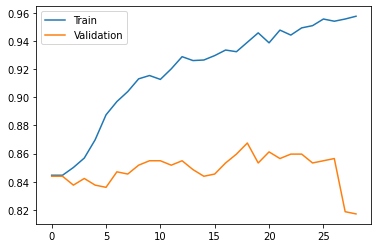

In [ ]:
plt.plot(acc, label = 'Train')
plt.plot(val_acc, label = 'Validation')
plt.legend()
plt.show()

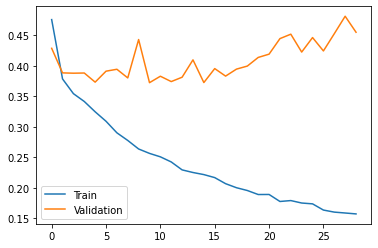

In [ ]:
plt.plot(loss, label = 'Train')
plt.plot(val_loss, label = 'Validation')
plt.legend()
plt.show()

In [ ]:
pred = best_model.predict(te_pt)

In [ ]:
test['target'] = [1 if p >= 0.5 else 0 for p in pred]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
test.to_csv('결과.csv', index = False)

In [89]:
data = pd.concat([train, test], axis = 0, ignore_index = True)

In [90]:
data.dropna(inplace = True)

In [91]:
data['구독자수'] = data['구독자수'].str[4:-1]

In [92]:
data['구독자수'] = [10000 * float(x[:-1]) if x[-1] == '만' else 1000 * float(x[:-1]) for x in data['구독자수']]

In [93]:
def preprocessing_num(x) :
    if x[-2] == '만' :
        return int(float(x[:-2]) * 10000)
    elif x[-2] == '천' :
        return int(float(x[:-2]) * 1000)
    else :
        return x[:-1]

In [94]:
data['조회수'] = data.조회수.apply(preprocessing_num).astype(int)

In [95]:
data['좋아요'] = data['좋아요'].str.replace(',', '')

In [96]:
data['좋아요'] = data['좋아요'].str.replace('없음', '0')

In [97]:
data['좋아요'] = [int(re.sub(r'[^0-9]+', ' ', x)) for x in data['좋아요']]

In [98]:
pn_score = data.groupby('파일명').target.agg(lambda x : sum(x) / np.size(x)).reset_index(name = '긍부정점수')

In [99]:
l_score = data.groupby('파일명').좋아요.mean().reset_index(name = '좋아요')

In [100]:
sc_score = data.groupby('파일명').구독자수.mean().reset_index(name = '구독자')

In [101]:
c_score =  data.groupby('파일명').조회수.mean().reset_index(name = '조회수')

In [102]:
data = data[['카테고리', '채널명', '파일명']]

In [103]:
data = pd.merge(data, pn_score)

In [104]:
data = pd.merge(data, l_score)

In [105]:
data = pd.merge(data, sc_score)

In [106]:
data = pd.merge(data, c_score)

In [107]:
from sklearn.preprocessing import MinMaxScaler

In [108]:
scaler = MinMaxScaler()

In [109]:
data['긍부정점수'] = scaler.fit_transform(data[['긍부정점수']]) * 30

In [110]:
data['구독자'] = scaler.fit_transform(data[['구독자']]) * 25

In [111]:
data['조회수'] = scaler.fit_transform(data[['조회수']]) * 30

In [112]:
data['좋아요'] = scaler.fit_transform(data[['좋아요']]) * 15

In [113]:
data['종합점수'] = data.iloc[:, 3:].sum(axis = 1)

In [114]:
result = data.groupby(['카테고리', '채널명']).종합점수.mean().reset_index()

In [122]:
for category in result['카테고리'].unique() :
  print(f'\n\n{category} 종합 점수 상위 5개 채널')
  display(result[result.카테고리 == category].sort_values(by = '종합점수', ascending = False).head(5))



IT 제품 종합 점수 상위 5개 채널


,카테고리,채널명,종합점수
2,IT 제품,ITSub잇섭,34.430440
20,IT 제품,테크몽 Techmong,31.599616
3,IT 제품,Liah Yoo,30.922102
7,IT 제품,노컷브이,30.467120
12,IT 제품,슈퍼개미 배진한 레슨몬TV,30.271566




OOTD 종합 점수 상위 5개 채널


,카테고리,채널명,종합점수
21,OOTD,1theK (원더케이),56.049453
40,OOTD,TRANS7 OFFICIAL,52.681457
32,OOTD,KBS WORLD TV,48.058331
35,OOTD,NCT,45.026904
22,OOTD,ALL THE K-POP,36.935229




남자 패션 종합 점수 상위 5개 채널


,카테고리,채널명,종합점수
93,남자 패션,하이틴에이저 Hi-teenager,73.199956
83,남자 패션,올리버쌤,37.334660
89,남자 패션,키작은 광자,34.767734
87,남자 패션,코디메이커피로,33.885979
68,남자 패션,깡스타일리스트,32.631773




노트북 종합 점수 상위 5개 채널


,카테고리,채널명,종합점수
105,노트북,주연 ZUYONI,31.860022
97,노트북,ITSub잇섭,30.796295
109,노트북,한대표,26.064085
103,노트북,이퓨,24.834830
106,노트북,탐구생활 - 돈이 되는 삶의 이야기,23.485946




모바일 종합 점수 상위 5개 채널


,카테고리,채널명,종합점수
117,모바일,김시선,61.649785
128,모바일,비누TV,36.490987
138,모바일,키에커,33.756348
110,모바일,Betosky,32.755903
112,모바일,Mobile Moba,30.984203




여자 패션 종합 점수 상위 5개 채널


,카테고리,채널명,종합점수
163,여자 패션,짤툰,38.881757
159,여자 패션,우왁굳의 게임방송,35.937224
161,여자 패션,잼스터,35.791365
165,여자 패션,코리안브로스,35.683273
147,여자 패션,깡스타일리스트,33.628820
